# TP parte 1

In [178]:
import pandas as pd
import numpy as np
import requests
from collections import Counter
import plotly.express as px
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
import seaborn as sns

#from sklearn.feature_extraction import FeatureHasher
#from sklearn.feature_selection import VarianceThreshold

#from sklearn.impute import KNNImputer, SimpleImputer
#from sklearn.preprocessing import (
    #KBinsDiscretizer,
    #LabelEncoder,
    #MinMaxScaler,
    #Normalizer,
    #OneHotEncoder,
    #OrdinalEncoder,
    #PowerTransformer,
    #RobustScaler,
    #StandardScaler,
#)

In [179]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("impuestos.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

# Introduccion 

El presente trabajo analizara determinados datos de personas que pagan impuestos brindados por una agencia gubernamental de recaudación de impuestos, la FIUFIP, con el objetivo de determinar si una persona posee altos ingresos o bajos ingresos.
La agencia tiene como principal objetivo determinar que individuos evaden los impuestos.

Los objetivos para este trabajo son
   * poder comprender los datos (viendolos y graficandolos)
   * ver como se relacionan entre ellos 
   * determinar patrones a partir de los graficos

Abrimos el data frame

In [180]:
df = pd.read_csv("impuestos.csv")

# Ingenieria de feautures  
Verificamos la calidad de los datos antes de visualizarlos.  

## Verificacion de datos faltantes
Primero verificamos aquellos valores que sean nulos. Con info() verificamos si los hay.

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            32561 non-null  int64 
 1   barrio                                      31978 non-null  object
 2   categoria_de_trabajo                        30725 non-null  object
 3   edad                                        32561 non-null  int64 
 4   educacion_alcanzada                         32561 non-null  object
 5   estado_marital                              32561 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64 
 7   genero                                      32561 non-null  object
 8   horas_trabajo_registradas                   32561 non-null  int64 
 9   religion                                    32561 non-null  object
 10  rol_familiar_registrad

Vemos que hay valores faltantes en las columnas de 'trabajo', 'barrio' y 'categoria de trabajo'. Los pasamos todos a nan.

In [182]:
#aniadir mas chequeos??
df.fillna(np.nan, inplace = True)
df.isnull().sum()

anios_estudiados                                 0
barrio                                         583
categoria_de_trabajo                          1836
edad                                             0
educacion_alcanzada                              0
estado_marital                                   0
ganancia_perdida_declarada_bolsa_argentina       0
genero                                           0
horas_trabajo_registradas                        0
religion                                         0
rol_familiar_registrado                          0
tiene_alto_valor_adquisitivo                     0
trabajo                                       1843
dtype: int64

Dado que tenemos tres columnas con datos faltantes, tenemos que resolverlos de alguna manera.
Para esto, tomamos las distintas decisiones:  
  *  Barrio: completamos con una nueva categoria.
  *  Categoria_de_trabajo: reempazamos los valores faltantes por "No respondio". 
  *  Trabajo: completamos con 'desempleado' ya que suponemos a priori que no repondio porque no tiene trabajo.

In [183]:
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].replace(np.nan, 'No inscripto')
df['trabajo'] = df['trabajo'].replace(np.nan, 'desempleado')#lo agreguge recien
categorias = df['categoria_de_trabajo'].value_counts(dropna=False)
trabajos = df['trabajo'].value_counts(dropna=False)
df['categoria_de_trabajo'].value_counts()

relacion_de_dependencia    22696
monotibutista               2541
empleado_municipal          2093
No inscripto                1836
empleado_provincial         1298
responsable_inscripto       1116
empleadao_estatal            960
trabajo_voluntariado          14
sin_trabajo                    7
Name: categoria_de_trabajo, dtype: int64

Queremos observar cuantas personas no completaron las columnas de 'trabajo' y 'categoria de trabajo'.

In [184]:
df.loc[(df['categoria_de_trabajo'] == 'No inscripto') & (df['trabajo'] == 'desempleado')]

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
27,14,Boedo,No inscripto,54,5_anio,matrimonio_civil,0,hombre,60,budismo,casado,1,desempleado
61,8,NaN,No inscripto,32,7-8_grado,pareja_no_presente,0,hombre,40,cristianismo,sin_familia,0,desempleado
69,14,Palermo,No inscripto,25,5_anio,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,0,desempleado
77,10,Palermo,No inscripto,67,1_anio,matrimonio_civil,0,hombre,2,cristianismo,casado,0,desempleado
106,10,Palermo,No inscripto,17,1_anio,sin_matrimonio,34095,mujer,32,cristianismo,con_hijos,0,desempleado
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32530,17,Palermo,No inscripto,35,universidad_3_anio,matrimonio_civil,0,mujer,55,cristianismo,casada,1,desempleado
32531,17,Palermo,No inscripto,30,universidad_3_anio,sin_matrimonio,0,mujer,99,budismo,sin_familia,0,desempleado
32539,20,Palermo,No inscripto,71,universiada_6_anio,matrimonio_civil,0,hombre,10,cristianismo,casado,1,desempleado
32541,13,Palermo,No inscripto,41,4_anio,separado,0,mujer,32,judaismo,sin_familia,0,desempleado


observamos que son unas pocas, en relacion a la cantidad de encuestados, las personas las que no completaron ninguno de los dos campos. Es por eso que decidimos borralos del dataset.

In [186]:
datos_a_borrar = (df['categoria_de_trabajo'] == 'No inscripto') & (df['trabajo'] == 'desempleado')
datos_a_borrar.value_counts()
df = df.drop(df.loc[datos_a_borrar].index,axis=0).reset_index(drop=True)
datos_a_borrar.value_counts()

False    30725
dtype: int64

Luego, decidimos completar las filas del atributo barrio que estaban en null con una nueva categoria como mencionamos antes. (a chequear estooo)y tambien otamos por dejar lo que no respondienron con su trabajo pero si con su categoria como desempleados.

In [187]:
#mediana_barrio = df['barrio'].mean()
#mediana_barrio

df['barrio'] = df['barrio'].replace(np.nan, 'Otro Barrio')
#df.loc['barrio'] = df.loc['barrio'].fillna(mediana_barrio)

barrio = df['barrio'].value_counts(dropna=False)
barrio

Palermo                27511
Belgrano                 610
Otro Barrio              556
San Isidro               188
Villa Urquiza            128
La Boca                  109
Recoleta                 107
Almagro                  100
Agronomia                100
Balvanera                 92
Puerto Madero             86
Caballito                 80
Boedo                     71
Barracas                  68
Chacarita                 68
Coghland                  67
Floresta                  64
Constitucion              63
Colegiales                59
Flores                    56
Liniers                   56
Nueva Pompeya             42
Mataderos                 42
Monte Castro              42
Monserrat                 34
nuñez                     33
Parque Chacabuco          30
Parque Avellaneda         29
Parque Chas               27
Villa Luro                27
La Paternal               24
Retiro                    19
Villa Soldati             18
Villa Devoto              18
San Telmo     

Ahora verificamos valores negativos en aquellos feautures donde deberian ser todos positivos.

In [93]:
columnas_con_numeros = ['edad', 'horas_trabajo_registradas']
print('con numeros negativos:')
(df[columnas_con_numeros] < 0).any()
#agregar chequeo de que en estas columnas solo hayan numeros

con numeros negativos:


edad                         False
horas_trabajo_registradas    False
dtype: bool

Vemos que no hay valores negativos en las edades ni en las horas trabajadas. (Nos falta chequear los valores que son numeros que no tengan strings)

Ahora verificamos si hay valores duplicados.

In [94]:
df[df.duplicated(keep=False)]

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
12,17,Palermo,relacion_de_dependencia,23,universidad_3_anio,sin_matrimonio,0,mujer,30,cristianismo,con_hijos,0,entretenimiento
17,13,Palermo,relacion_de_dependencia,32,4_anio,sin_matrimonio,0,hombre,40,cristianismo,soltero_a,0,inspector
20,20,Palermo,relacion_de_dependencia,40,universiada_6_anio,matrimonio_civil,0,hombre,60,cristianismo,casado,1,profesional_especializado
26,13,Palermo,relacion_de_dependencia,19,4_anio,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,0,reparador
28,13,Palermo,relacion_de_dependencia,49,4_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,0,reparador
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30673,13,Palermo,relacion_de_dependencia,47,4_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,0,reparador
30682,13,Palermo,relacion_de_dependencia,20,4_anio,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,0,inspector
30696,14,Palermo,relacion_de_dependencia,22,5_anio,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,0,entretenimiento
30721,13,Palermo,relacion_de_dependencia,40,4_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,1,inspector


Podemos ver que hay varias filas repetidas. Vemos que los valores que se repiten con mas frecuencia son el barrio donde reside cada persona, su categoria de trabajo, la religion y la perdida de ganancia. Concluimos que, dado que el resto de los datos varia, se trata de distintas personas. Es por esto que decidimos dejarlas.

## Conversion de variables  
Convertimos aquellas variables categoricas, ya sean ordinales y no ordinales. Empezamos por aquellas variables ordinales, las cuales son:  
    - First item educacion alcanzada

In [95]:
#unique_educacion_alcanzada = df['educacion_alcanzada'].value_counts(dropna=False)
#oe = OrdinalEncoder()
#columns_to_encode = ['educacion_alcanzada']
#try:
#    df[['educacion_alcanzada_encoded']] = oe.fit_transform(
 #       df[columns_to_encode]
 #   )
#except Exception as upa:
#    print(upa)

#print(unique_educacion_alcanzada)
#df['educacion_alcanzada_encoded']

Ahora vemos que las variables categoricas no ordinales son:
    -barrio
    -categoria_de_trabajo
    -

In [96]:
# Usando pandas profiling
report = ProfileReport(df, title='impuestos', explorative=True, lazy=False)
report

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

/home/sol/.local/lib/python3.8/site-packages/pandas_profiling/visualisation/plot.py:154: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Visualizacion de datos   

## Primero nos hacemos una serie de preguntas para comprender y analizar mejor nuestros datos:  
 1. Como esta relacionado el genero de una persona con su poder adquisitivo?
 2. Es determinante el nivel de estudios alcanzados?
     - como esta relacionado con el rol familar o estado marital
 3. Como afecta la edad de una persona con el poder adquisitivo?
     - la cantidad de horas trabajadas esta relacionado con el tipo de oficio?
     - que relacion hay entre el tipo de trabajo de una persona con las ganacias perdidas en la bolsa 
 4. Como influyen los gastos mensuales de una persona?
 5. el nivel de estuidos alcanzados determina que una persona posea altos ingresos? ya la hicimos mas arriba
 
Buscamos entender cada uno de los datos, cómo se relacionan entre sí y ver que conclusiones podemos obtener. A partir de ellos vamos a determinar los factores que determinan si alguien tiene altos o bajos ingresos.

### Como esta relacionada el genero de una persona con su poder adquisitivo?
    

<AxesSubplot:ylabel='genero'>

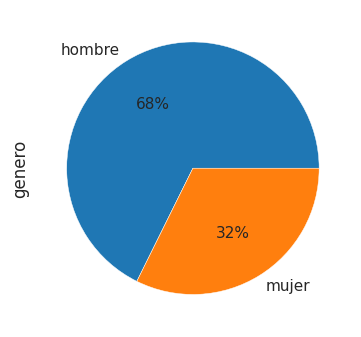

In [97]:
plt.figure(figsize=(5.4, 3.8), dpi=110)
df['genero'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)

Se puede observar que la mayoria de los encuentados fueron hombres. 
Intuimos que los que van a tener un mayor poder adquisitivo van a ser personas del genero masculino. Para ver eso, calculamos la proporcion de cada genero que posee altos ingresos.

<AxesSubplot:ylabel='tiene_alto_valor_adquisitivo'>

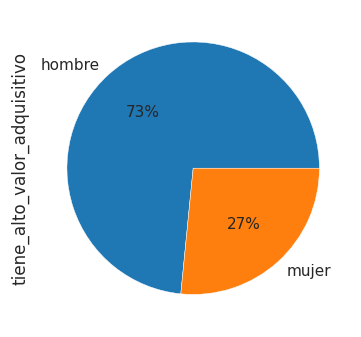

In [98]:
proporciones_adquisitivo = df.groupby(by='genero')['tiene_alto_valor_adquisitivo'].agg('mean')
total_personas_con_poder_adquisitivo = proporciones_adquisitivo['mujer'] + proporciones_adquisitivo['hombre']
proporciones_adquisitivo['hombre'] = proporciones_adquisitivo['hombre']/total_personas_con_poder_adquisitivo
proporciones_adquisitivo['mujer'] = proporciones_adquisitivo['mujer']/total_personas_con_poder_adquisitivo

plt.figure(figsize=(5.4, 3.8), dpi=110)
proporciones_adquisitivo.plot(
    kind='pie', autopct='%1.0f%%'
)

De por si, es bajo el porcentaje de encuestados que posee altos ingresos. De esa cantidad de personas podemos ver que es mayor el porcentaje de hombres que de mujeres como habiamos predicho en el grafico de tortas.

Queremos ver la relacion del trabajo con el alto o bajo poder adquisitivo.

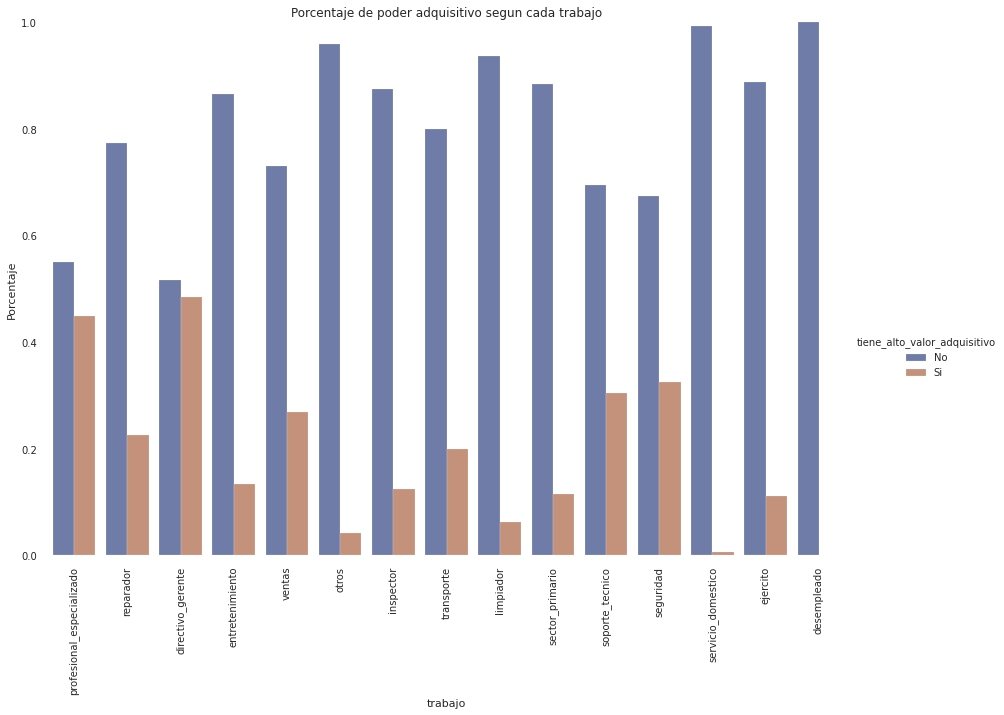

In [99]:
trabajo_por_poder_adq = df.groupby(by="trabajo")['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)

trabajo_por_poder_adq = trabajo_por_poder_adq.to_frame()
trabajo_por_poder_adq.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de respuestas'},inplace=True)
trabajo_por_poder_adq.reset_index(inplace=True)
trabajo_por_poder_adq['tiene_alto_valor_adquisitivo'].replace([0,1],['No','Si'],inplace=True)

g = sns.catplot(
    data=trabajo_por_poder_adq, kind="bar",
    x="trabajo", y="Cantidad de respuestas", hue="tiene_alto_valor_adquisitivo", order=df["trabajo"].value_counts().iloc[:20].index,
    ci=None, palette="dark", alpha=.6, height=8,aspect=1.5
)
plt.title("Porcentaje de poder adquisitivo segun cada trabajo")
g.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
g.set_axis_labels("trabajo", "Porcentaje")

Podemos ver que para todos los trabajos hay mas personas que consideran que no tienen un alto poder adquisitivo. Vemos que los que tienen un poder adquisitivo mayor y que se encuentran con porcentajes cercanos son profesional especializado y gerente directivo. Los que poseen menor poder adquisitivo son el servicio domestico, los desempleados y 'otros'.  
Ahora que visualizamos el valor adquisitivo segun el trabajo, queremos observar como se distribuyen los distintos empleos segun el genero.

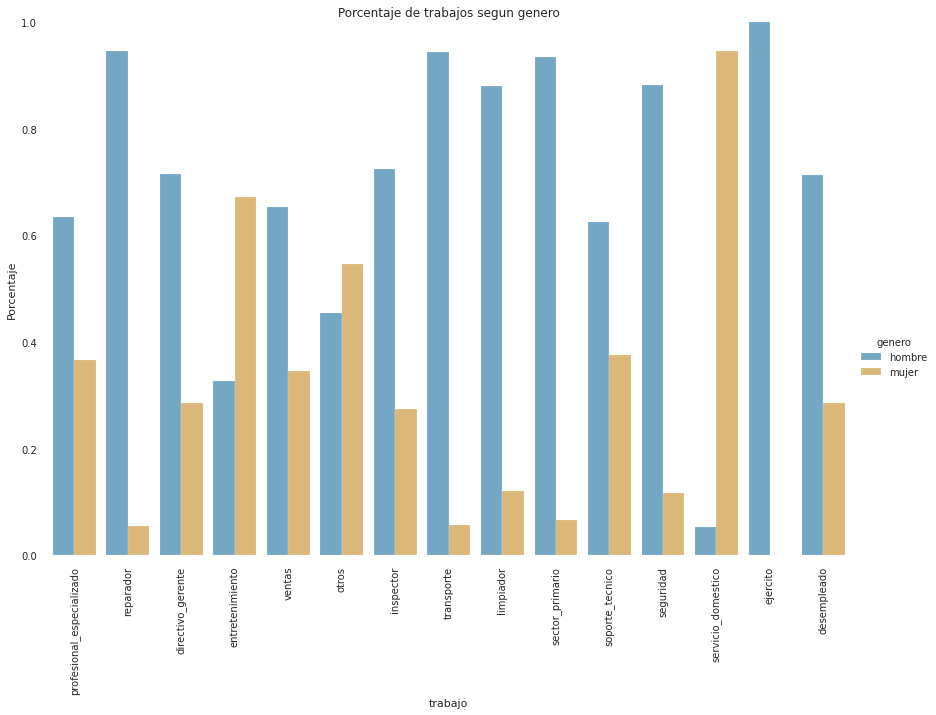

In [100]:
trabajo_por_genero = df.groupby(by="trabajo")['genero'].value_counts(normalize=True)
trabajo_por_genero = trabajo_por_genero.to_frame()
trabajo_por_genero.rename(columns={'genero':'Cantidad de respuestas'},inplace=True)
trabajo_por_genero.reset_index(inplace=True)

g = sns.catplot(
    data=trabajo_por_genero, kind="bar",
    x="trabajo", y="Cantidad de respuestas", hue="genero", order=df["trabajo"].value_counts().iloc[:20].index,
    ci=None, palette="colorblind", alpha=.6, height=8,aspect=1.5
)
plt.title("Porcentaje de trabajos segun genero")
g.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
g.set_axis_labels("trabajo", "Porcentaje")

relacion_de_dependencia    22696
monotibutista               2541
empleado_municipal          2093
empleado_provincial         1298
responsable_inscripto       1116
empleadao_estatal            960
trabajo_voluntariado          14
sin_trabajo                    7
Name: categoria_de_trabajo, dtype: int64

Luego de ver como se relacionan el genero con el tipo de trabajo, concluimos que los trabajos con menor poder adquisitivo se distribuyen entre las mujeres, como por ejemplo los trabajos en el area de entretenimiento, servicio domestico y 'otros'.

Tambien observamos que los que tienen un mayor poder adquisitivo se distribuyen entre los hombres. Estos trabajos son los previamente mencionados, profesional especializado y directivo gerente.

Concluimos entonces que el bajo poder adquisitivo, en su mayoria entre las mujeres, se debe al trabajo realizado.  

## Es determinante el nivel de estudios alcanzados?

Queremos obtener una conclusion sobre que tan importante es el nivel de estudios alcanzados a la hora de determinar si una persona tiene altos ingresos. Primero queremos saber su relacion con el alto poder adquisitivo declarado por las personas encuestadas.  

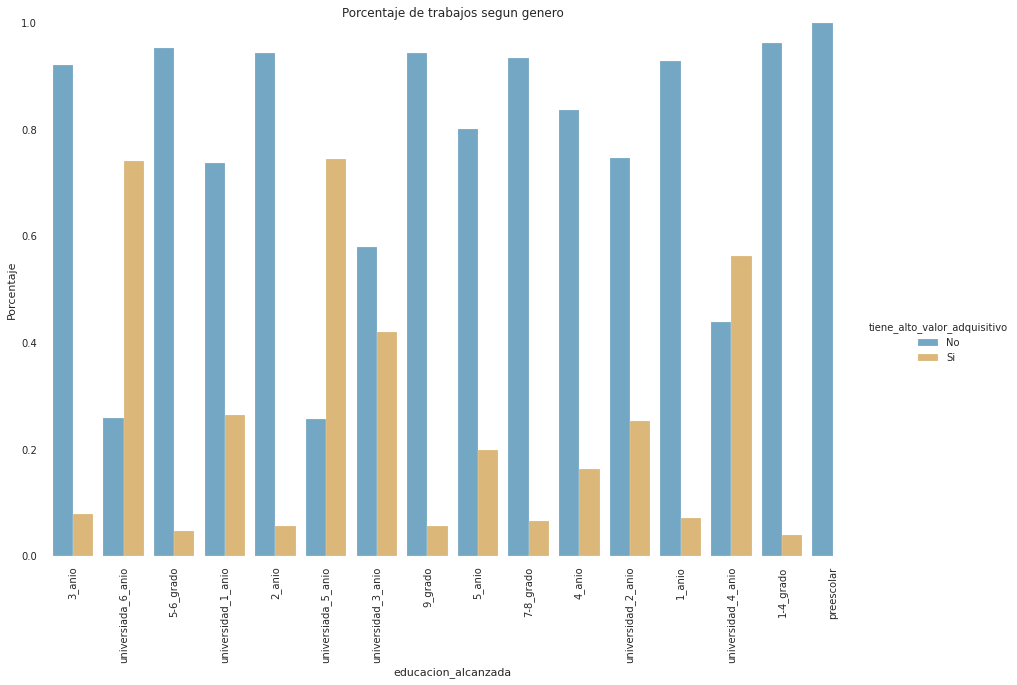

In [101]:
estudios_y_poder_adquisitivo = df.groupby(by="educacion_alcanzada")['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)

estudios_y_poder_adquisitivo = estudios_y_poder_adquisitivo.to_frame()
estudios_y_poder_adquisitivo.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de respuestas'},inplace=True)
estudios_y_poder_adquisitivo.reset_index(inplace=True)
estudios_y_poder_adquisitivo['tiene_alto_valor_adquisitivo'].replace([0,1],['No','Si'],inplace=True)

g = sns.catplot(
    data=estudios_y_poder_adquisitivo, kind="bar",
    order=estudios_y_poder_adquisitivo["educacion_alcanzada"].value_counts().iloc[:20].index,
    x="educacion_alcanzada", y="Cantidad de respuestas", hue="tiene_alto_valor_adquisitivo", 
    ci=None, palette="colorblind", alpha=.6, height=8,aspect=1.5
)

plt.title("Porcentaje de trabajos segun genero")
g.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
g.set_axis_labels("educacion_alcanzada", "Porcentaje")

#ver si se puede ordenar

Podemos ver claramente que cuanto mayor sea el nivel de educacion alcanzado, mayor es el poder adquisitivo. Ademas dentro de los anios universitarios podemos ver diferencias significativas a medida que uno va avanzando en la carrera, siendo los anios mas altos los de mayor porcentaje de personas con alto poder adquisitivo.

Ahora queremos observar como se relaciona el nivel de educacion alcanzado con el trabajo realizado. Para esto, dividimos los niveles de educacion alcanzada en cuatro categorias:  
    - Preescolar  
    - Primario  
    - Secundario  
    - Universidad  

In [102]:
def agrupar_educacion_alcanzada(educacion):

    if educacion.find("universiada") >= 0:
        return "universitario"
    elif educacion.find("anio") >= 0:
        return "secundario"
    elif educacion.find("grado") >= 0:
        return "primario"
    else:
        return "preescolar"

In [103]:
estudios_alcanzados_y_trabajo = df.filter(['educacion_alcanzada', 'trabajo'],axis = 1)

estudios_alcanzados_y_trabajo['educacion_alcanzada'] = estudios_alcanzados_y_trabajo['educacion_alcanzada'].astype('string')
estudios_alcanzados_y_trabajo['educacion_alcanzada'] = estudios_alcanzados_y_trabajo['educacion_alcanzada'].apply(agrupar_educacion_alcanzada)
                                                                                                                  
unique_educacion_alcanzada = estudios_alcanzados_y_trabajo['educacion_alcanzada'].value_counts(dropna=False)
unique_educacion_alcanzada

secundario       28227
primario          1496
universitario      956
preescolar          46
Name: educacion_alcanzada, dtype: int64

relacion_de_dependencia    22696
monotibutista               2541
empleado_municipal          2093
empleado_provincial         1298
responsable_inscripto       1116
empleadao_estatal            960
trabajo_voluntariado          14
sin_trabajo                    7
Name: categoria_de_trabajo, dtype: int64

Procedemos a realizar un heatmap para visualizar los datos

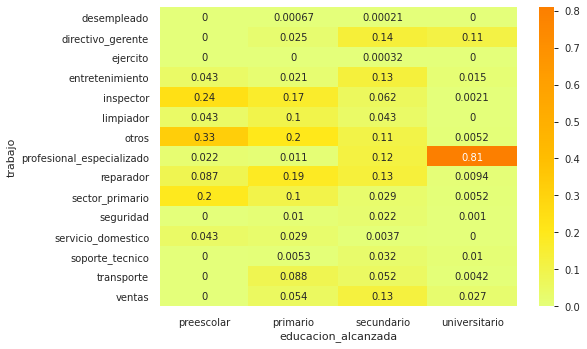

In [104]:
ct_counts = estudios_alcanzados_y_trabajo.groupby(['educacion_alcanzada', 'trabajo']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'trabajo', columns = 'educacion_alcanzada', values = 'count')
ct_counts = ct_counts.fillna(0)
ct_counts['preescolar'] = ct_counts['preescolar']/ct_counts['preescolar'].sum()
ct_counts['primario'] = ct_counts['primario']/ct_counts['primario'].sum()
ct_counts['secundario'] = ct_counts['secundario']/ct_counts['secundario'].sum()
ct_counts['universitario'] = ct_counts['universitario']/ct_counts['universitario'].sum()
sns.heatmap(ct_counts, cmap="Wistia", annot=True)
plt.show()

Observando los datos, podemos ver que los empleos que poseen un mayor poder adquisitivo (visto prevamente) son realizados mayormente por universitarios, siendo estos lo que declaron el tener mayores ingresos. 
falta conclusion.

## Como afecta la edad de una persona con el poder adquisitivo?


Analizamos en que rango de edades se encuentran los encuentados. 

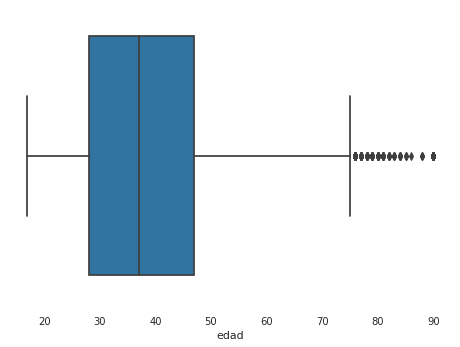

In [105]:
sns.boxplot(x=df["edad"])
plt.show()

Podemos ver que la mayoria de los encuestados tiene entre 27 y 47 anios. 
Ahora nos preguntamos si tiene algo que ver con la edad el trabajo que uno realiza. A priori podriamos asumir que una persona mayor de 30 anios ya posee un trabajo profesional especializado o puede llegar a ser gerente de una empresa antes que una persona de 20 anios, que recien puede estar estudiando y arrancando su vida laboral. 

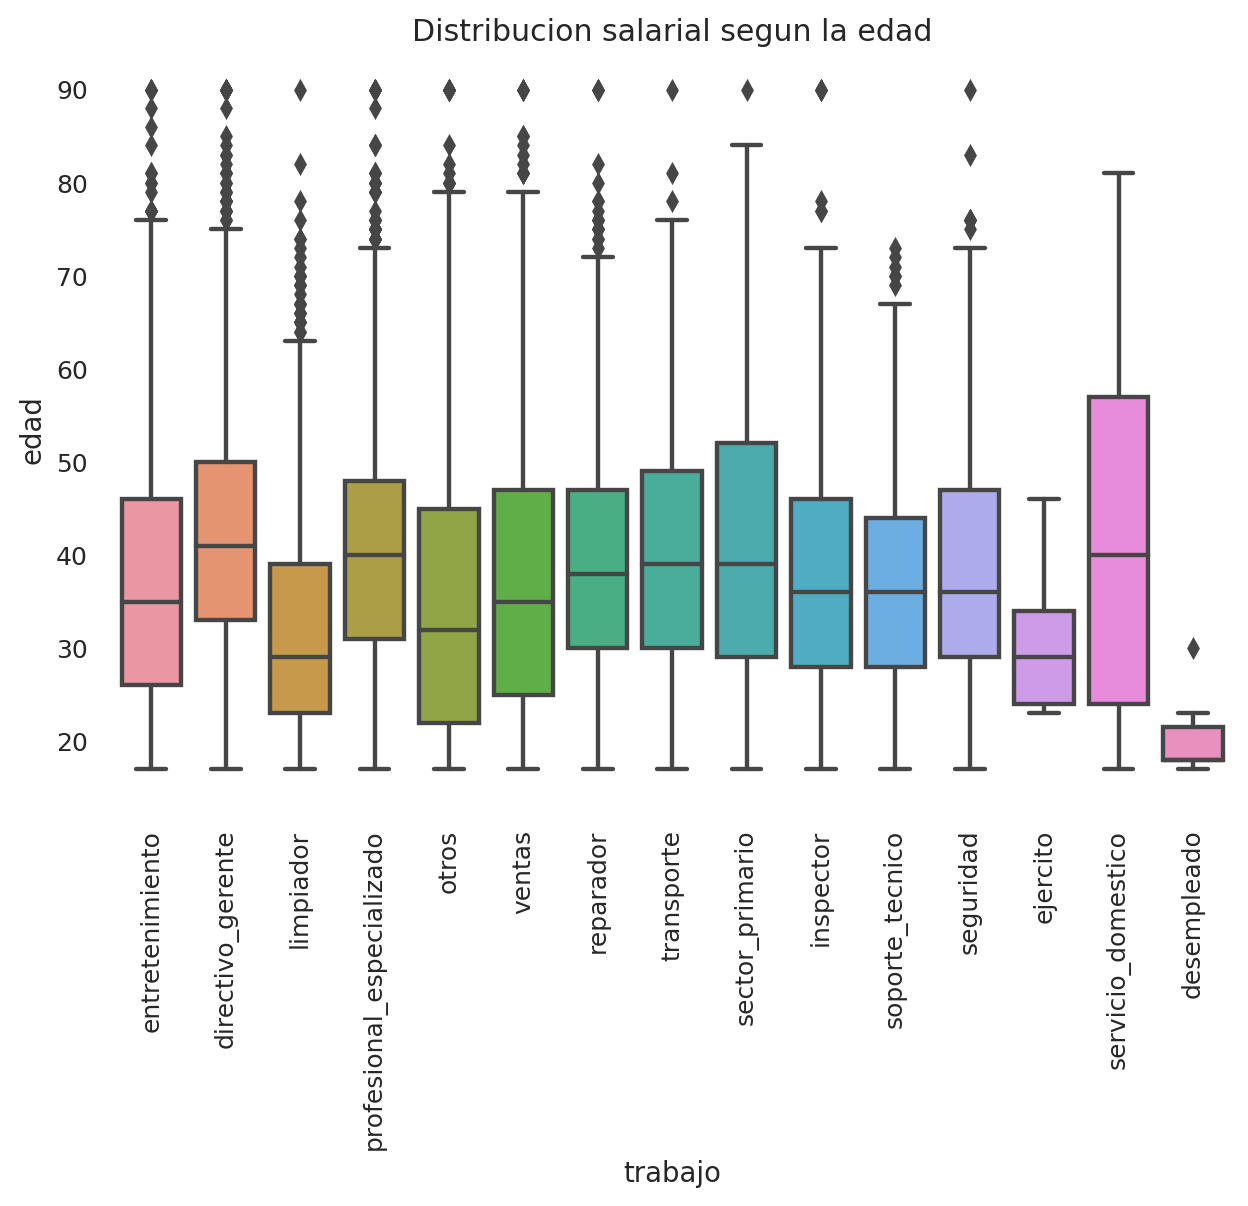

In [106]:
plt.figure(dpi=180)
plt.title("Distribucion salarial segun la edad")
#sns.catplot(data=df, x= 'trabajo', y='edad')
sns.boxplot(x="trabajo", y="edad", data=df)
plt.xticks(rotation=90)
plt.show()

Al analizar el grafico, confirmamos nuestras hipotesis sobre la relacion entre la edad y el trabajo, ya que vemos que los empleos como directivo gerente y prefesional especializdo son realizados por personas con edad superior a los 30 anios mientras que otros trabajos como limpiador o directamente alguien deseempleado (tal vez cambiar eso de desempleado porque es suposicion nuestra) tienen las personas con una edad al rededor de los 20 donde podrian recien estar arrancando en el ambito laboral.

Queremos relacionar la edad con el alto poder adquisitivo que posee una persona.

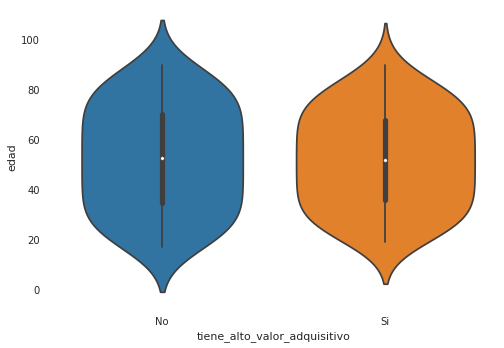

In [107]:
edad_y_poder_adquisitivo = df.groupby(by="edad")['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)

edad_y_poder_adquisitivo = edad_y_poder_adquisitivo.to_frame()
edad_y_poder_adquisitivo.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de respuestas'},inplace=True)
edad_y_poder_adquisitivo.reset_index(inplace=True)
edad_y_poder_adquisitivo['tiene_alto_valor_adquisitivo'].replace([0,1],['No','Si'],inplace=True)
sns.violinplot(x="tiene_alto_valor_adquisitivo", y="edad", data=edad_y_poder_adquisitivo,
                    order=["No", "Si"])
plt.show()

viendo el grafico, no notamos que la edad sea un factor influyente en cuanto a tener o no un gran poder adquisitivo. Vemos que los dos graficos se distribuyen de manera similar tanto entre quienes declararon tener altos ingresos como para quienes declararon lo contrario.


## Como influyen los gastos mensuales de una persona?

Un factor importante a tener en cuenta cuando hablamos de tener altos ingresos son los gastos mensuales. Esto (podria inlcuir quizas, mas como hipotessis)incluiria el barrio en el que reside una persona, ya sea por gastos de alquiler o impuestos. Tambien el rol familiar, es decir, si uno tiene hijos o no, si esta casado o es soltero y su estado marital tambien podria influir.
consulta: se podri incluir aca como gasto la inversion en la bolsa??

Como primer caso, analizamos el rol familar del encuestado. Como primer analisis se podria pensar que una persona que tiene hijos va a tener un mayor valor adquisitivo debido que se tienen mayores gastos, ya que se estan manteniendo las necesidades de estos, que una persona soltera sin hijos cuyos gastos son solo los de si mismo.

Vemos como es la distribucion del rol familiar de los encuentados.

In [108]:
roles_familiares =df['rol_familiar_registrado'].value_counts(normalize=True).round(2)
roles_familiares

casado         0.41
sin_familia    0.26
con_hijos      0.15
soltero_a      0.11
casada         0.05
otro           0.03
Name: rol_familiar_registrado, dtype: float64

El ser casado o casada bajo el analisis del rol familiar con los gatos no nos intersa ver el genero por lo que decidimos juntarlos como esta hecho en soltero_a

In [111]:
estado_persona = df.filter(['rol_familiar_registrado', 'tiene_alto_valor_adquisitivo', 'estado_marital'],axis = 1)
estado_persona['rol_familiar_registrado'] = estado_persona['rol_familiar_registrado'].replace('casado', 'casado_a')
estado_persona['rol_familiar_registrado'] = estado_persona['rol_familiar_registrado'].replace('casada', 'casado_a')
roles_familiares = estado_persona['rol_familiar_registrado'].value_counts(normalize=True).round(2)

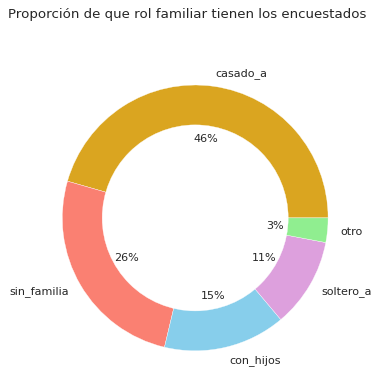

In [112]:
circulo_centro=plt.Circle( (0,0), 0.7, color='white')
plt.figure(dpi=80)
plt.pie(roles_familiares.values, labels=roles_familiares.index.to_list(), colors=['goldenrod','salmon','skyblue','plum', 'lightgreen', 'lightsteelblue'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(circulo_centro)
plt.suptitle('Proporción de que rol familiar tienen los encuestados')
plt.show()

Se puede visualizar que hay un gran porcentaje que esta casado y solo el 15% de los encuestados tienen hijos que era un factor importae a tener en cuenta en el tener altos ingresos. 
Ahora analizamos su alto poder adquisitivo.

In [113]:
estado_persona.groupby(by='rol_familiar_registrado').agg({'tiene_alto_valor_adquisitivo':'mean'}).round(2)

,tiene_alto_valor_adquisitivo
rol_familiar_registrado,
casado_a,0.46
con_hijos,0.01
otro,0.04
sin_familia,0.11
soltero_a,0.07


Observamos que los que tienen mayor poder adquisitivo son las personas que estan casadas.
Vemos como se relaciona esto con el estado marital de la persona y como influye con el tener alto valor adquisitivo.

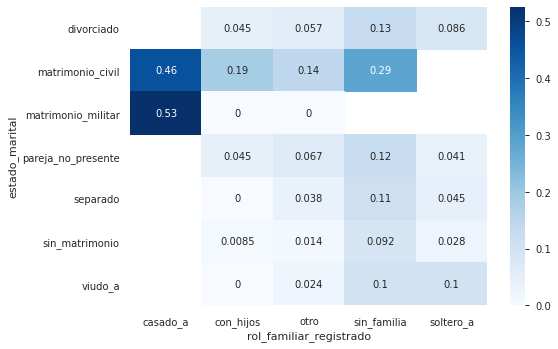

In [114]:
#relacion_persona_y_poder_adquisitivo = estado_persona.pivot(index = 'estado_marital', columns = 'rol_familiar_registrado', values = 'tiene_alto_valor_adquisitivo')
relacion_persona_y_poder_adquisitivo = pd.pivot_table(data = estado_persona, index = 'estado_marital', columns = 'rol_familiar_registrado', values = 'tiene_alto_valor_adquisitivo', aggfunc = 'mean')

sns.heatmap(relacion_persona_y_poder_adquisitivo, cmap="Blues", annot=True)
plt.show()

Observamos que los que tienen un mayor poder adquisitivo son las personas casadas ya sea por civil o militar. Ademas se puede observar que de todos los que tienen hijos las que posen un mayor poder adquisitivo son las personas que tienen un matrimonio por civil y que si la pareja no esta presente o estan sepadaros o sin matrimonio o divorciados el tener hijos hace que no tenga un alto poder adquisitivo. Tiene sentido ya que el tener hijos es un gasto considerable y el mantenerlo solo hace que el poder adquisitivo baje. 
# comentario: matrimonicio civil pero sin familia ??? rari  

El otro factor de gasto a tener en cuenta es el barrio. Como idea prinipial podemos pensar que el barrio influye fuertemente en determinar si una persona presenta altos ingresos debido a que de acuerdo al barrio el alquiler es mas caro, o mismo los impuestos, entre otros factores. Por ejemplo una persona que vive en once no paga lo mismo de alquier que una persona que vive en recoleta. La primera pagara mucho menos.  

In [115]:
alto_poder_adquisitivo_por_barrio = df.groupby(by="barrio")['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)
alto_poder_adquisitivo_por_barrio = alto_poder_adquisitivo_por_barrio.to_frame()
alto_poder_adquisitivo_por_barrio.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de encuestas'},inplace=True)
alto_poder_adquisitivo_por_barrio.reset_index(inplace=True)

alto_poder_adquisitivo_por_barrio['tiene_alto_valor_adquisitivo'].replace([0,1],['No','Si'],inplace=True)

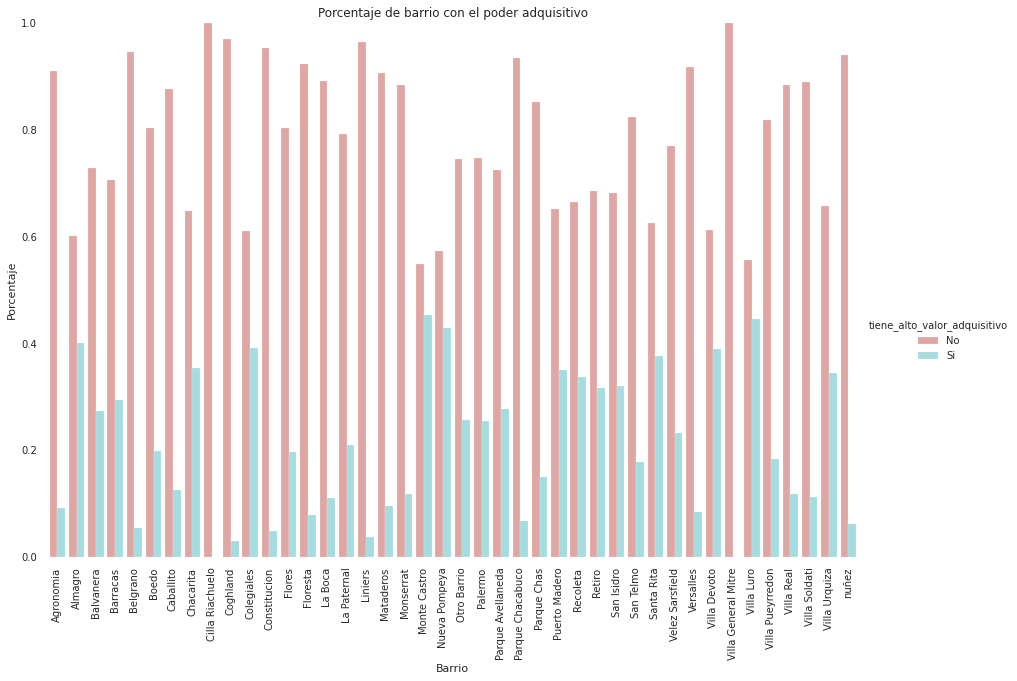

In [116]:
grafico = sns.catplot(
    data=alto_poder_adquisitivo_por_barrio, kind="bar",
    x="barrio", y="Cantidad de encuestas", hue="tiene_alto_valor_adquisitivo",
    ci=None, palette="hls", alpha=.6, height=8,aspect=1.5
)
plt.title("Porcentaje de barrio con el poder adquisitivo")
grafico.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
grafico.set_axis_labels("Barrio", "Porcentaje")

Observamos que el barrio no influye en el poder adquisitivo de la manera esperada, sino que independientemente del barrio hay un mayor porcentaje de no a que si. 
Los barrios que tienen un mayor porcentaje de residentes con un alto poder adquisitivo son Nueva Pompeya, Monte Castro, Almagro, Colegiales,Villa Luro, villa deboto, chararita. Barrios donde ....

Por ultimo un tercer factor es la ganancia o perdida en la bolsa. Como hipotesis podemos decir que una persona que invierte en la bolsa tiene un alto poder adquisitivo independientemente de si perdio o gano ya que tiene ese dinero extra que no fue utilizado en gastos se utilizo para invertir. Tambien pensamos que no muchas personas van a invertir en la bolsa.

In [41]:
inversion_bolsa = df['ganancia_perdida_declarada_bolsa_argentina'].value_counts(normalize=True).round(2)
inversion_bolsa

 0        0.87
 15024    0.01
 7688     0.01
 7298     0.01
-1902     0.01
          ... 
 22040    0.00
 7978     0.00
 1173     0.00
 2387     0.00
-1944     0.00
Name: ganancia_perdida_declarada_bolsa_argentina, Length: 207, dtype: float64

Vemos que la mayoria tiene como ganancia o perdida en la bolsa cero. Esto puede ser porque no decidieron invertir o por que entre la ganancia y la perdida dio cero. Como hay distintos valores positivo como negativos para el analisis vamos a clasificarlos en 3 categorias: Ganacia (los valores mayores a cero), perdida (los valores negativos) y Nula (los que tienen cero). 

In [42]:
def agrupar_valor_bolsa(valor):

    if valor > 0:
        return "Ganancia"
    elif valor < 0:
        return "Perdida"
    else:
        return "Nulo"

In [44]:
valor_bolsa = df.filter(['ganancia_perdida_declarada_bolsa_argentina', 'tiene_alto_valor_adquisitivo'] ,axis = 1)

valor_bolsa['ganancia_perdida_declarada_bolsa_argentina'] = valor_bolsa['ganancia_perdida_declarada_bolsa_argentina'].apply(agrupar_valor_bolsa)
valor_bolsa['ganancia_perdida_declarada_bolsa_argentina']  = valor_bolsa['ganancia_perdida_declarada_bolsa_argentina'].astype('string')                                                                                                                 
unique_valor_bolsa = valor_bolsa['ganancia_perdida_declarada_bolsa_argentina'].value_counts(dropna=False)
unique_valor_bolsa

Nulo        26675
Ganancia     2589
Perdida      1461
Name: ganancia_perdida_declarada_bolsa_argentina, dtype: Int64

Corroboramos que no son muchas las personas que invierten en la bolsa argentina. 
Ahora estudiaremos como afecta este atributo con el valor adquisitivo. 

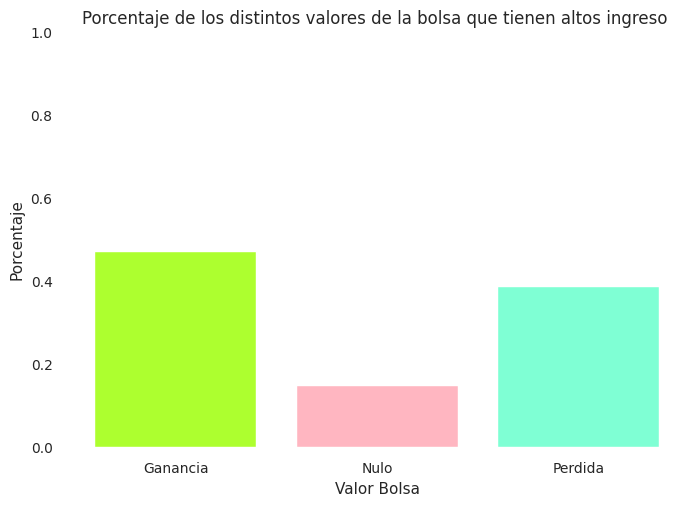

In [45]:
porcentaje_valor_bolsa = valor_bolsa.groupby(by='ganancia_perdida_declarada_bolsa_argentina')['tiene_alto_valor_adquisitivo'].agg('mean')
total_personas_con_poder_adquisitivo = porcentaje_valor_bolsa['Ganancia'] + porcentaje_valor_bolsa['Perdida'] + porcentaje_valor_bolsa['Nulo']
porcentaje_valor_bolsa['Ganancia'] = porcentaje_valor_bolsa['Ganancia']/total_personas_con_poder_adquisitivo
porcentaje_valor_bolsa['Perdida'] = porcentaje_valor_bolsa['Perdida']/total_personas_con_poder_adquisitivo
porcentaje_valor_bolsa['Nulo'] = porcentaje_valor_bolsa['Nulo']/total_personas_con_poder_adquisitivo
plt.figure(dpi=100)
plt.bar(porcentaje_valor_bolsa.index, porcentaje_valor_bolsa.values, color = ['greenyellow','lightpink', 'aquamarine'])
plt.ylabel("Porcentaje")
plt.xlabel("Valor Bolsa")
plt.ylim(0, 1)
plt.title('Porcentaje de los distintos valores de la bolsa que tienen altos ingreso ')
plt.show()

Podemos visualizar como el tener mas ganancias o perdidas hacen que uno tenga alto poder adquisitivo que es como predijimos antes. Con el simple hecho de invertir nos muestra que una persona tiene altos ingresos(independientemente de si le fue bien o mal). Lo que nos brinda el grafico es que hay una pequenia diferencia entre ganancia y perdida mostrando que el tener ganancia en la bolsa muestra que tienen una mayor probabilidad de tener altos ingresos.

#Primero nos preguntamos cuales son los datos que nos van a ayudar a determinar lo pedido
#Para eso nos hacemos una serie de preguntas:

#DUDA: la educacion alcanzada-> cuando no aclara que tipo de educacion que hacemos.
#DUDA: hacer el promedio de cuantos anios dura una carrera, para tomar en cuenta sien funcion de su tiempo de estudio termino o no

#Influye la edad y el genero de la persona?

#Y sus  anios de educacion junto con el nivel de educacion alcanzado?

#Su estado marital junto con su religion? (posiblemente no)

#Vemos que los datos que pueden estar relacionados en cuanto a gastos mensuales son: barrio, rol familiar, o de la perdida en la Esto nos puede ayudar a 
#concluir si una persona tiene un alto poder adquisitivo.

#cuantas horas trabaja en relacion al trabajo que realiza y su categoria. (depende de la categoria lo que te sacan de impuestos)

#vemos que tenemos datos como la religion que no aporta informacion acerca del poder asquisitivo de una persona (consultar
#si se pueden volar los datos sin graficarlos)

# Da igual la categoria de trabajo de cada persona o es un factor a tener en cuenta?
Nos preguntamos si segun el trabajo dependera la categoria de trabajo. En otras palabras, si lo que se aporta en impuestos depende del trabajo. A priori predecimos que si, ya que lo que se paga de impuestos depende fuertemente de lo que se gana.  
Realizamos un heatmap para ver mejor la correlacion entre el trabajo y la categoria de trabajo.

In [188]:
def normalizar_categorias(df_categorias):
    categorias = df_categorias.columns.values.tolist()

    for categoria in categorias:
        df_categorias[categoria] = df_categorias[categoria] / df_categorias[categoria].sum()
    return df_categorias

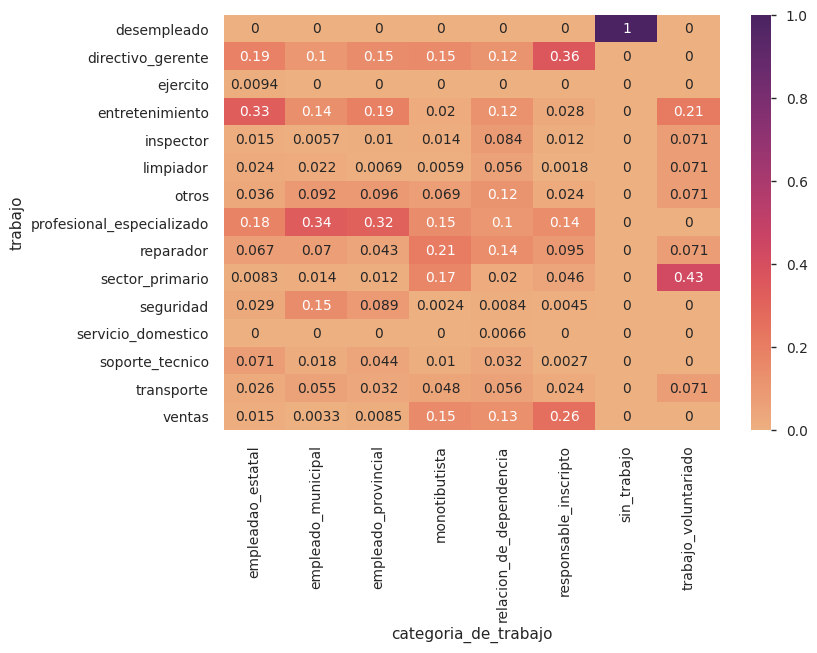

In [203]:
categoria_de_trabajo_vs_trabajo = df.filter(['categoria_de_trabajo', 'trabajo'],axis = 1)
ct_counts = categoria_de_trabajo_vs_trabajo.groupby(['categoria_de_trabajo', 'trabajo']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot_table(index = 'trabajo', columns = 'categoria_de_trabajo', values = 'count',aggfunc = 'mean')
ct_counts = ct_counts.fillna(0)
ct_counts = normalizar_categorias(ct_counts)
plt.figure(dpi=100)
sns.heatmap(ct_counts, cmap="flare", annot=True)
plt.show()

Por un lado podemos observar que hay una fuerte correlacion entre la categoria agregada "desempleado" para reemplazar los datos que eran faltantes en la columna de "trabajo", junto con la categoria "sin_trabajo" dentro de la columna "categoria_de_trabajo".

Por otro lado, las categorias estan distribuidos de manera amplia entre los distintos trabajos. (ceqeuarrr)
No podemos predecir que una persona vaya a tener altos ingresos o bajos a partir del analisis de la relacion entre el trabajo y su categoria. Por eso debemos seguir con los analisis.  

Nos preguntamos, como se relaciona la categoria de trabajo con las horas trabajadas. Por eso, queremos visualizar estos datos en conjunto para ver si podemos obtener una conclusion a partir de ellos.

In [ ]:
horas_trabajadas_vs_categoria = df.filter(['categoria_de_trabajo','horas_trabajo_registradas'],axis = 1)
plt.figure(dpi=100)
sns.swarmplot(x="categoria_de_trabajo", 
                y="horas_trabajo_registradas", 
                data=df.sample(n = 800),
                 size = 3)

plt.xticks(rotation=90)
plt.show()